In [19]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/anaconda3/envs/DL/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['step']
`%matplotlib` prevents importing * from pylab and numpy



## Parameters tuning

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from NetEmbs import *
updateCONFIG(False)

Config file has been updated!


### Helper funciton to aggregate the raw results

In [32]:
MIN_NUM = 9
def add_average(df, on="V-M", postfix=["_N_global", "_N-"+str(MIN_NUM)+"_global", "_N_local", "_N-"+str(MIN_NUM)+"_local"], inplace=False):
    """
    Helper function to add a column with average values over the given metric
    :param df: input DataFrame
    :param on: Metric name
    :param postfix: List of postfixes to be used for calculation the average
    :param inplace: If False, return a copy of original DF with added column
    :return: None if inplace=True or DataFrame if inplace=False
    """
    avg_titles = [on + it for it in postfix]
    if inplace:
        df["AVG_" + on] = df.apply(lambda row: np.mean([row[title] for title in avg_titles]), axis=1)
        return
    else:
        df_local = df.copy()
        df_local["AVG_" + on] = df_local.apply(lambda row: np.mean([row[title] for title in avg_titles]), axis=1)
        return df_local
    
def get_best_combinations(df, on="V-M", postfix=["_N_global", "_N-"+str(MIN_NUM)+"_global", "_N_local", "_N-"+str(MIN_NUM)+"_local"]):
    df_avg = add_average(df, on=on, postfix=postfix)
    return df_avg.groupby(["Strategy", "Pressure", "Walks per node", "Window size", "Embedding size", "Train steps"])\
        [["AVG_"+on]+[on+it for it in postfix]].mean()\
        .sort_values("AVG_"+on, ascending=False)

# Calculate aggregated stat for each combination of parameters

In [23]:
CONFIG.ROOT_FOLDER = "UvA/MarcelData/"
RESULT_FILE = "GRID_Result.xlsx"
tuning = pd.read_excel(CONFIG.ROOT_FOLDER + RESULT_FILE, index_col=0)
tuning.head(2)
t = get_best_combinations(tuning, on="V-M").reset_index()
t.to_excel(CONFIG.ROOT_FOLDER+"RealDataTuning.xlsx")
t.head(3)

,Strategy,Pressure,Walks per node,Window size,Embedding size,Train steps,AVG_V-M,V-M_N_global,V-M_N-9_global,V-M_N_local,V-M_N-9_local
0,MetaDiff,1,30,1,48,100000,0.666377,0.635953,0.667802,0.724895,0.636860
1,MetaDiff,1,30,2,48,50000,0.656754,0.632380,0.669387,0.717077,0.608174
2,MetaDiff,1,30,1,48,50000,0.655511,0.611478,0.643365,0.726392,0.640809


# Local sensitivity analysis

In [30]:
full_names_map = {"V-M": "V-Measure", "FMI": "Fowlkes-Mallows index", "AMI": "Adjusted Mutual Information", "ARI": "Adjusted Rand index"}
    
def get_required_metric(df, on="Pressure", metric="V-M"):
    df = add_average(df, on=metric)
    postfix=["AVG_"+metric]+[metric+it for it in ["_N_global", "_N-"+str(MIN_NUM)+"_global", "_N_local", "_N-"+str(MIN_NUM)+"_local"]]
    rename_map = dict(zip(postfix, ["Final Score", "N clusters, global", f"N-{str(MIN_NUM)} clusters, global", "N clusters, local", f"N-{str(MIN_NUM)} clusters, local"]))
    nominal = {"Walks per node": 50, "Window size": 3, "Pressure": 10, "Embedding size": 8, "Train steps": 50000}
    group_key = list(nominal.keys())
    group_key.remove(on)
    to_plot = df\
                .groupby(group_key).get_group(tuple([nominal[it] for it in group_key]))[[on]+postfix]\
                .rename(rename_map, axis=1)
    return to_plot
def plotSensitivity(df, on="Pressure", metric="V-M", mode="final"):
    df = get_required_metric(df, on=on, metric=metric)
    if mode=="final":
        sns.set_context("paper", font_scale=2)
        fig_size = (6.4, 4.8)
        fig = plt.figure(figsize=fig_size)
        ax = fig.add_subplot(111)
        sns.lineplot(x=df.columns[0], y="Final Score", data=df, marker="s", markersize=7, lw=2, err_style="band", err_kws={"alpha": 0.08}, ax=ax)
    elif mode=="all":
        sns.set_context("paper", font_scale=2)
        df = df.set_index(on).stack().reset_index().rename({"level_1": "", 0: "score"}, axis=1)
        fig_size = (12,6)
        fig = plt.figure(figsize=fig_size)
        ax = fig.add_subplot(111)
#         df["alpha"] = np.where(df[""] == "Final score", 1.0, 0.5)
        sns.lineplot(x=df.columns[0], y="score", hue="", alpha=0.25, data=df[df[""]!="Final Score"], \
                     palette = sns.color_palette("muted", 5)[1:][::-1], \
                     marker="s", markersize=7, err_style="band", err_kws={"alpha": 0.05}, ax=ax)
        sns.lineplot(x=df.columns[0], y="score", hue="", alpha=1, lw=3, data=df[df[""]=="Final Score"], marker="s", markersize=7, err_style="band", err_kws={"alpha": 0.1}, ax=ax)
        ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False, markerscale=2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    if on=="Train steps":
        import matplotlib.ticker as ticker
        plt.xlim(None,105000)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}K"))
    ax.set_xlabel(df.columns[0], labelpad=15)
    ax.set_ylabel(full_names_map[metric]+" Score", labelpad=15)
    fig.savefig(CONFIG.ROOT_FOLDER+full_names_map[metric]+"_ErrorBar_for_" + df.columns[0].replace(" ", "_") + "_" + mode+".png", bbox_inches="tight", dpi=140, pad_inches=0.05)

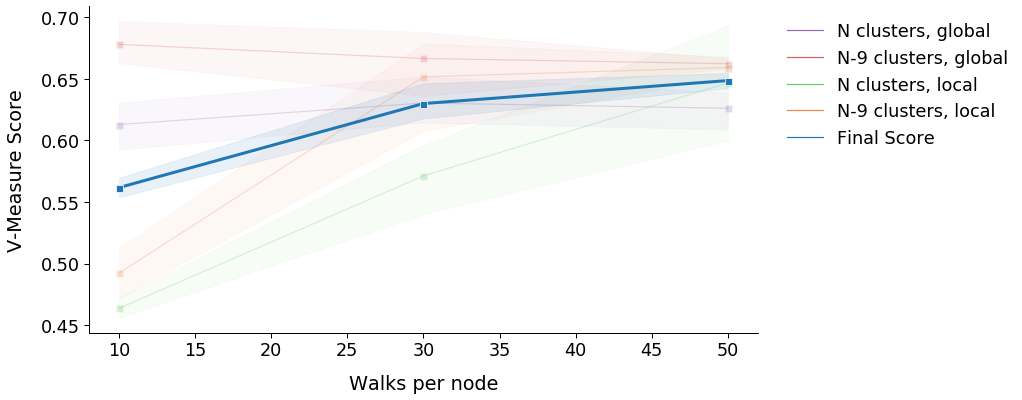

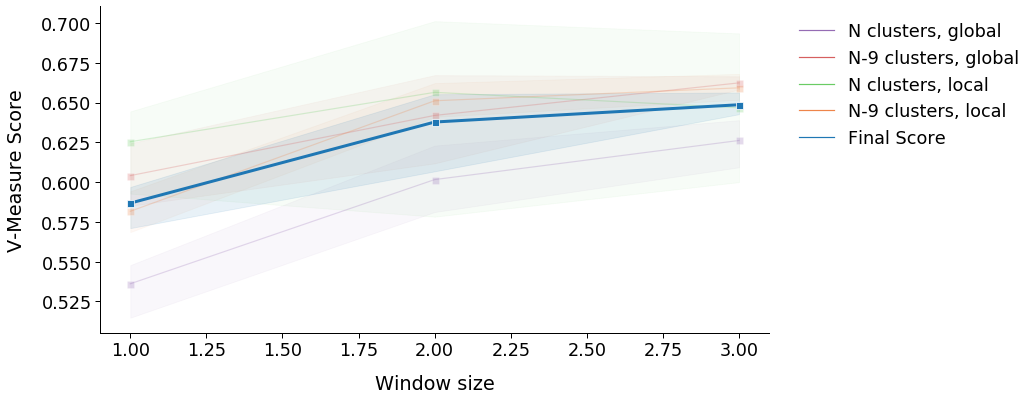

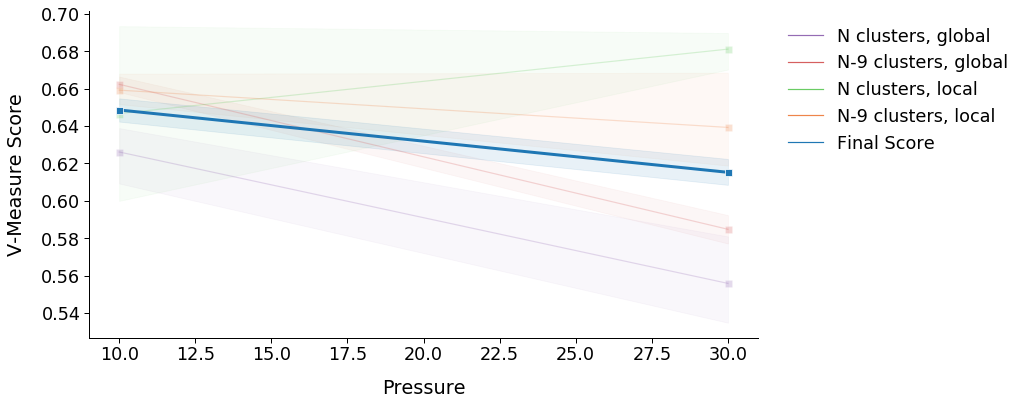

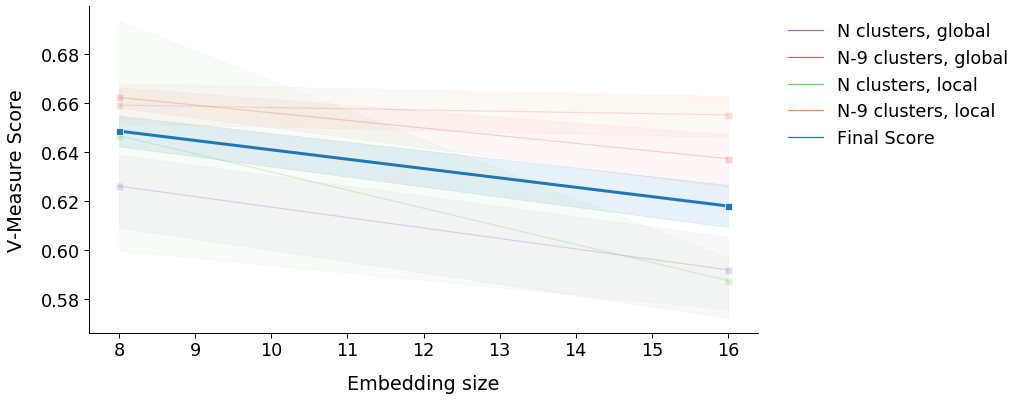

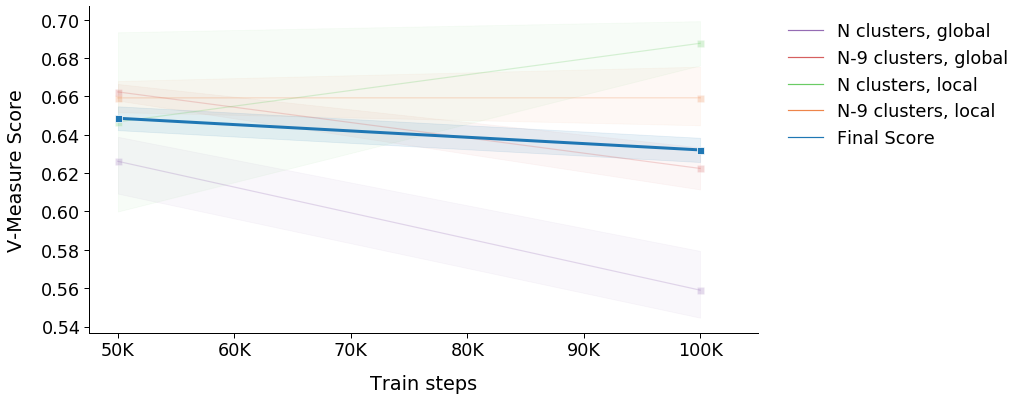

In [31]:
for title in ["Walks per node", "Window size", "Pressure", "Embedding size", "Train steps"]:
    plotSensitivity(tuning, metric="V-M", on=title, mode="all")